### import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR  

from scipy import stats

import pickle

%matplotlib inline

### import dataset

The `insurance.csv` dataset contains 17436 observations (rows) and 7 features (columns). <br>
The dataset contains 4 numerical features (age, bmi, children and expenses) and 3 nominal features (sex, smoker and region)

In [2]:
data = pd.read_csv('insurance.csv')

## Data Exploration

In [3]:
data.head(4)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47


In [4]:
data.tail(4)

,age,sex,bmi,children,smoker,region,expenses
17432,60,female,18.3,0,no,northeast,13204.29
17433,26,female,22.2,0,no,northwest,3176.29
17434,23,male,27.4,1,no,northwest,2789.06
17435,62,male,21.4,0,no,southwest,12957.12


In [5]:
data.sample(5)

,age,sex,bmi,children,smoker,region,expenses
1423,19,female,23.4,2,no,southwest,2913.57
11961,44,female,26.4,0,no,northwest,7419.48
7084,59,male,28.8,0,no,northwest,12129.61
15086,44,female,29.8,2,no,southeast,8219.20
9692,30,male,27.6,1,no,northeast,4237.13


In [6]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

### Exploratory Data  Analysis

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17436 entries, 0 to 17435
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       17436 non-null  int64  
 1   sex       17436 non-null  object 
 2   bmi       17436 non-null  float64
 3   children  17436 non-null  int64  
 4   smoker    17436 non-null  object 
 5   region    17436 non-null  object 
 6   expenses  17436 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 953.7+ KB


In [8]:
data.describe()

,age,bmi,children,expenses
count,17436.000000,17436.000000,17436.000000,17436.000000
mean,39.240594,30.668192,1.099851,13317.751637
std,14.127044,6.053742,1.202692,12139.935529
min,18.000000,16.000000,0.000000,1121.870000
25%,26.000000,26.300000,0.000000,4746.340000
50%,39.000000,30.400000,1.000000,9447.380000
75%,51.000000,34.800000,2.000000,16657.720000
max,64.000000,53.100000,5.000000,63770.430000


## Data Cleaning
Check for NaN values in the dataset

In [9]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

columns and their contents

In [10]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(col, ':', data[col].unique())
    else:
        print(col, ':', data[col].nunique())

age : 47
sex : ['female' 'male']
bmi : 275
children : 6
smoker : ['yes' 'no']
region : ['southwest' 'southeast' 'northwest' 'northeast']
expenses : 1337


## Feature Engineering

### Binning

In [11]:
bins = [0.0, 18.5, 24.9, 29.9, 60]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
data['bmi_cat'] = pd.cut(data['bmi'], bins, labels=labels)

### Categorical to Numerical Encoding

In [12]:
le = LabelEncoder()

data['children'] = le.fit_transform(data['children'])
data['smoker'] = le.fit_transform(data['smoker'])

In [13]:
ohe = OneHotEncoder() 

data['sex'] = ohe.fit_transform(data[['sex']]).toarray()

regional_area = pd.DataFrame(ohe.fit_transform(data[['region']]).toarray(), columns = ['NE', 'NW', 'SE', 'SW'])

In [14]:
bmi_bins = pd.DataFrame(ohe.fit_transform(data[['bmi_cat']]).toarray(), 
                        columns= ['Normal', 'Obese', 'Overweight', 'Underweight'])

In [15]:
data = pd.concat([ data.iloc[:,:2], data.iloc[:,7:8], bmi_bins, data.iloc[:,3:6], regional_area, data.iloc[:,-2:-1]], axis=1)

## Analytics and Visualization

In [16]:
data.sample(3)

,age,sex,bmi_cat,Normal,Obese,Overweight,Underweight,children,smoker,region,NE,NW,SE,SW,expenses
3112,59,1.0,Normal,1.0,0.0,0.0,0.0,0,1,northwest,0.0,1.0,0.0,0.0,25678.78
11877,18,0.0,Overweight,0.0,0.0,1.0,0.0,1,0,southeast,0.0,0.0,1.0,0.0,1719.44
17354,63,1.0,Normal,1.0,0.0,0.0,0.0,0,0,northeast,1.0,0.0,0.0,0.0,14449.85


### Statistical Analysis

In [17]:
for i in range(len(data.columns)-1):
    if data.columns[i] in ['region', 'bmi_cat']:
        continue
        
    print(data.columns[i])
    
    #for numerical-numerical
    if data.columns[i] in ['age', 'bmi']:
        
        pearson_coef, p_val = stats.pearsonr(data[data.columns[i]], data['expenses'])
        print('Pearson Coefficient :',pearson_coef,'\nP Value :',p_val,'\n')
        
        spearman_coef, p_val = stats.spearmanr(data[data.columns[i]], data['expenses'])
        print('Spearman Coefficient :',spearman_coef,'\nP Value :',p_val,'\n\n')
        
    #fot numerical-categorical    
    else:
        #one-way ANOVA
        F, p = stats.f_oneway(data[data.columns[i]],data['expenses'])
        print('F-Statistic=%.3f, p=%.3f\n\n' % (F, p))
        

age
Pearson Coefficient : 0.29672719905168704 
P Value : 0.0 

Spearman Coefficient : 0.5326230392750726 
P Value : 0.0 


sex
F-Statistic=20981.842, p=0.000


Normal
F-Statistic=20982.888, p=0.000


Obese
F-Statistic=20981.742, p=0.000


Overweight
F-Statistic=20982.475, p=0.000


Underweight
F-Statistic=20983.356, p=0.000


children
F-Statistic=20979.937, p=0.000


smoker
F-Statistic=20982.757, p=0.000


NE
F-Statistic=20982.637, p=0.000


NW
F-Statistic=20982.637, p=0.000


SE
F-Statistic=20982.546, p=0.000


SW
F-Statistic=20982.641, p=0.000




In [18]:
data.corr()

,age,sex,Normal,Obese,Overweight,Underweight,children,smoker,NE,NW,SE,SW,expenses
age,1.000000,0.027066,-0.089848,0.087029,-0.006595,-0.059573,0.041060,-0.034976,0.006292,-0.001799,-0.010406,0.006312,0.296727
sex,0.027066,1.000000,0.022621,-0.042797,0.022813,0.021470,-0.021204,-0.081456,0.002925,0.005332,-0.015394,0.007723,-0.057482
Normal,-0.089848,0.022621,1.000000,-0.466516,-0.285418,-0.054457,0.001900,0.008172,0.086690,0.024841,-0.088570,-0.019714,-0.114657
Obese,0.087029,-0.042797,-0.466516,1.000000,-0.682317,-0.130184,0.002777,0.008567,-0.091715,-0.082075,0.166504,0.001112,0.202323
Overweight,-0.006595,0.022813,-0.285418,-0.682317,1.000000,-0.079647,-0.001228,-0.018655,0.009472,0.060505,-0.090485,0.023910,-0.116326
Underweight,-0.059573,0.021470,-0.054457,-0.130184,-0.079647,1.000000,-0.012591,0.009927,0.077653,0.034715,-0.075323,-0.034317,-0.046180
children,0.041060,-0.021204,0.001900,0.002777,-0.001228,-0.012591,1.000000,0.004138,-0.026164,0.025526,-0.024577,0.026177,0.069631
smoker,-0.034976,-0.081456,0.008172,0.008567,-0.018655,0.009927,0.004138,1.000000,0.000546,-0.032236,0.065497,-0.036306,0.787966
NE,0.006292,0.002925,0.086690,-0.091715,0.009472,0.077653,-0.026164,0.000546,1.000000,-0.321309,-0.346352,-0.320108,0.006856
NW,-0.001799,0.005332,0.024841,-0.082075,0.060505,0.034715,0.025526,-0.032236,-0.321309,1.000000,-0.346352,-0.320108,-0.038614


### Plot Features vs 'expenses'

In [19]:
def numerical(num):
    sns.scatterplot(x=data[num], y = data['expenses'])
    plt.xlabel(num)
    plt.ylabel('Expenses')
    plt.title('{n} vs Expenses'.format(n = num))
    plt.show()

In [20]:
 def categorical(depen_var):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,8))
        fig.suptitle('{c} vs {n}'.format(c = depen_var.upper(), n = 'Expenses'))
        
        sns.boxplot(ax=axes[0], x = data[depen_var], y = data['expenses'])
        axes[0].set_title('Boxplot')

        sns.barplot(ax=axes[1],  x = data[depen_var], y = data['expenses'])
        axes[1].set_title('Bar Chart')

        plt.show()

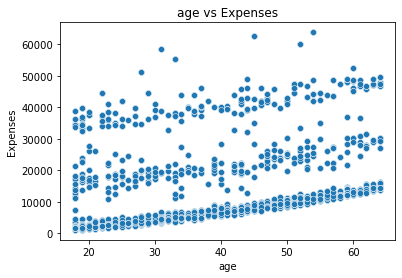

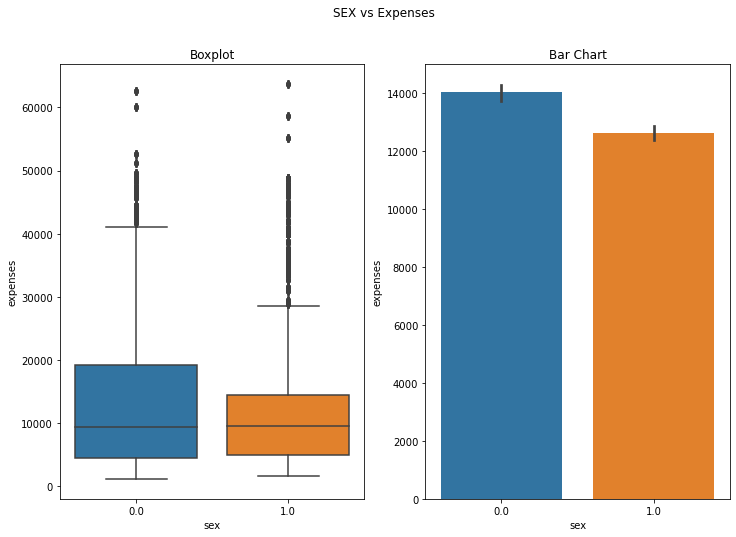

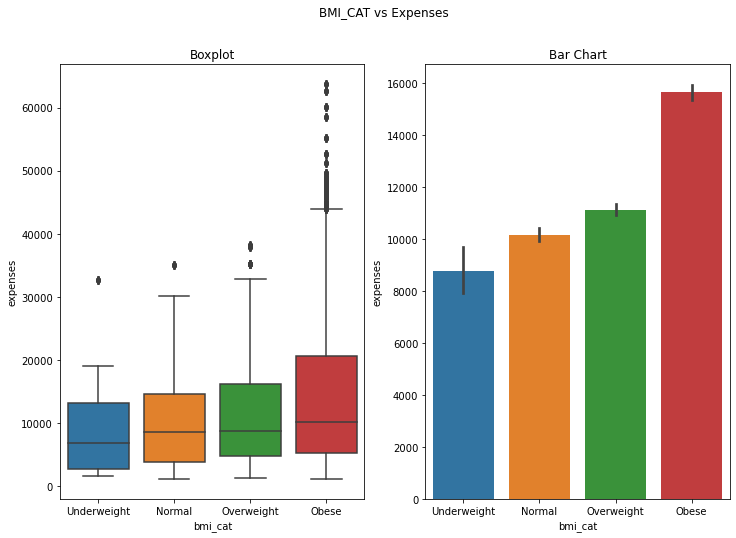

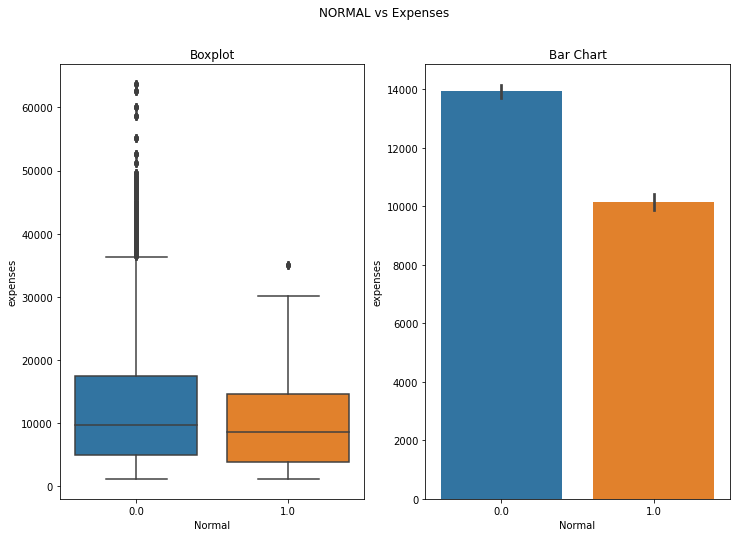

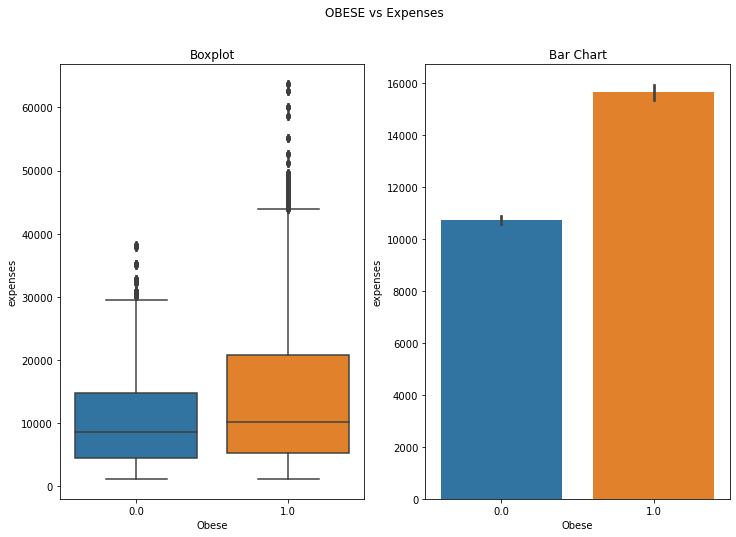

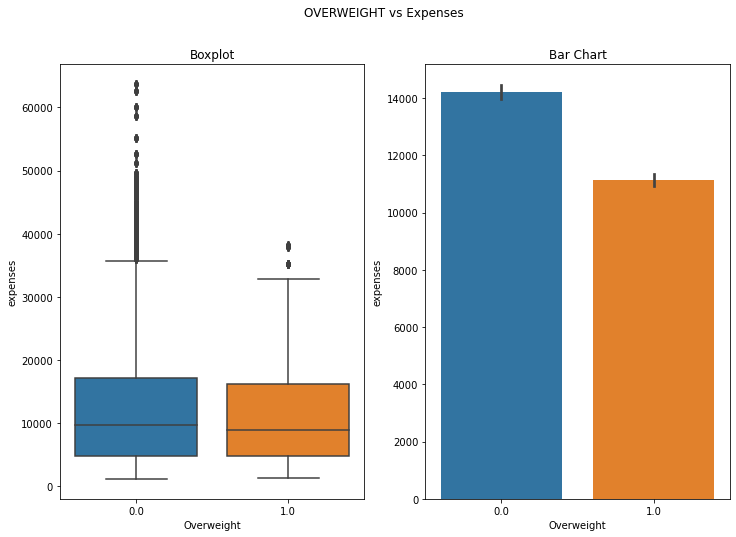

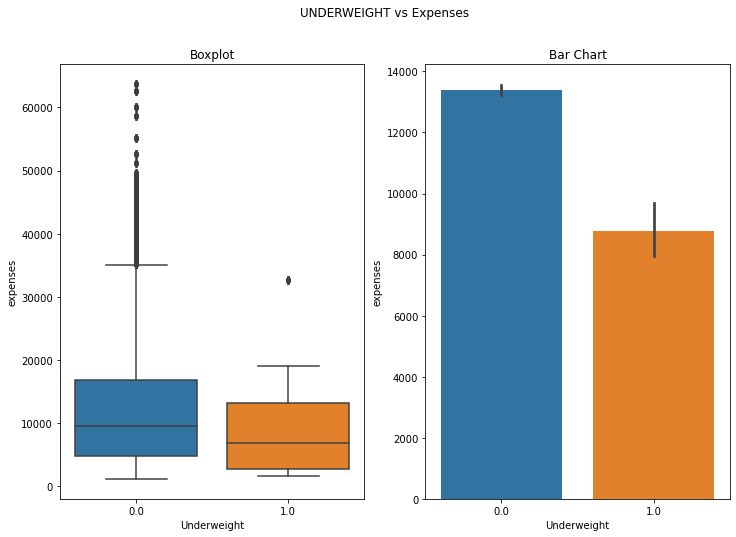

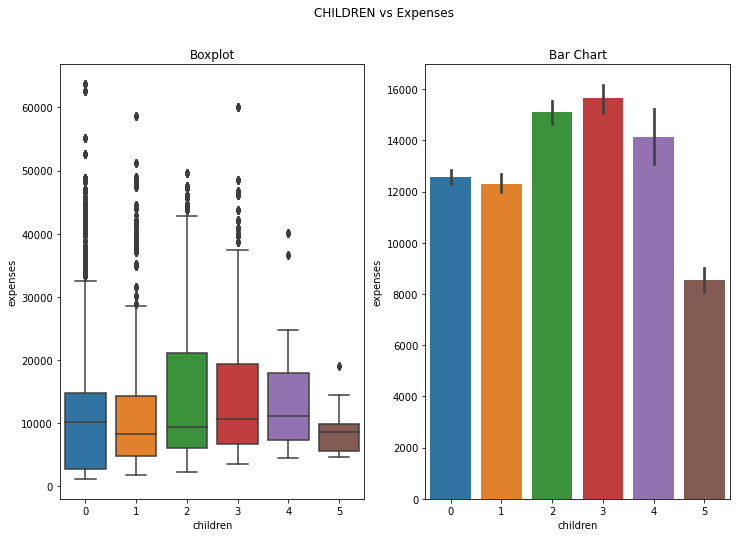

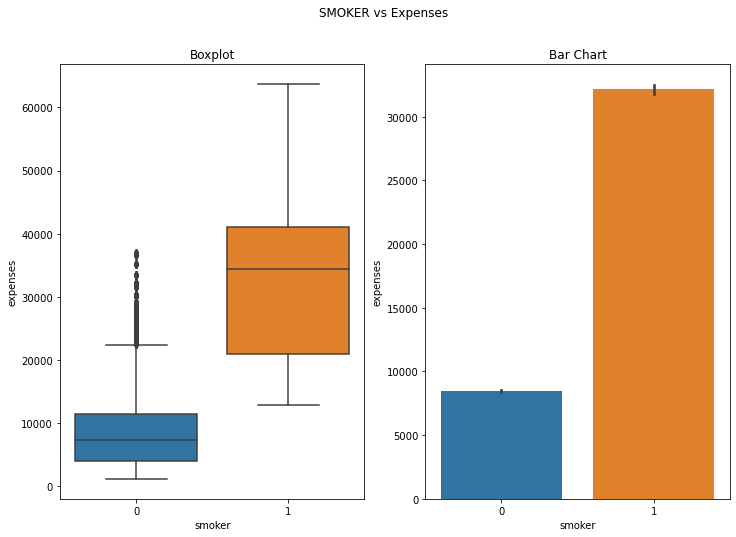

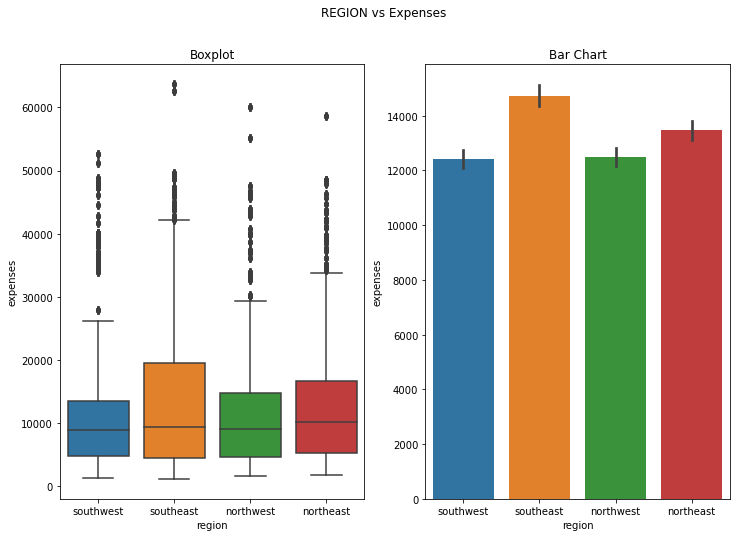

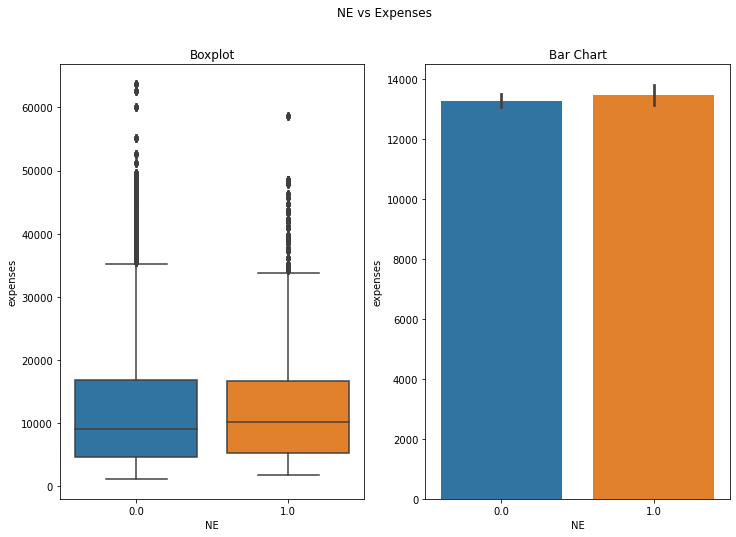

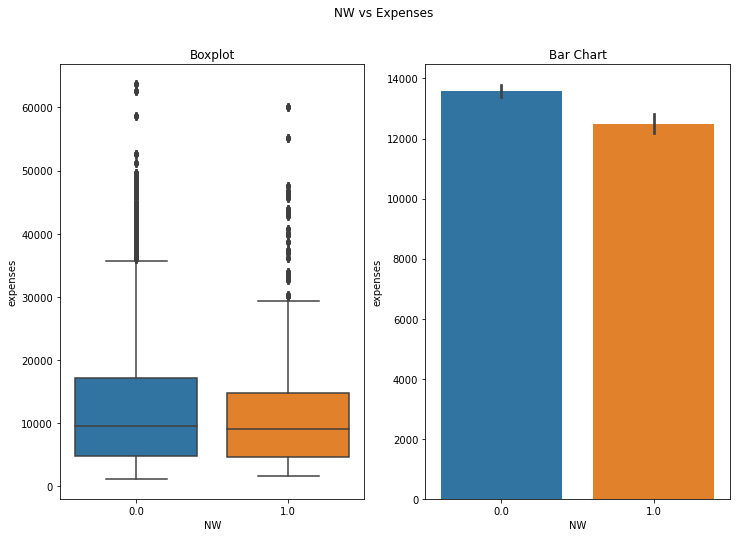

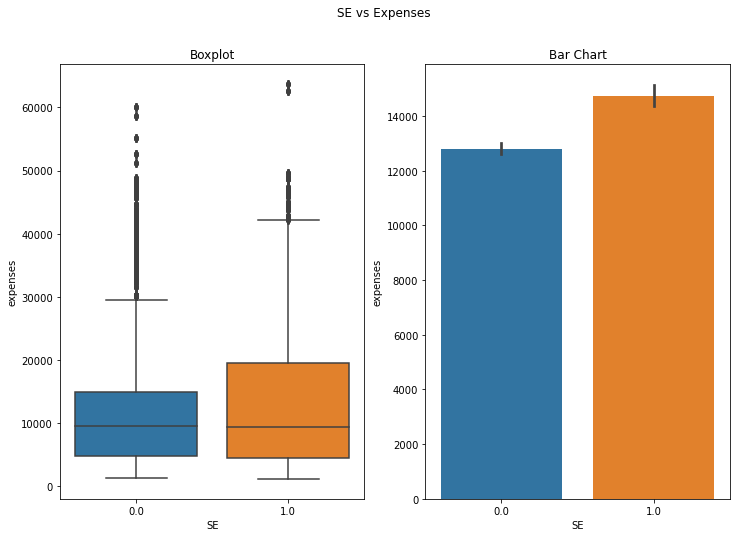

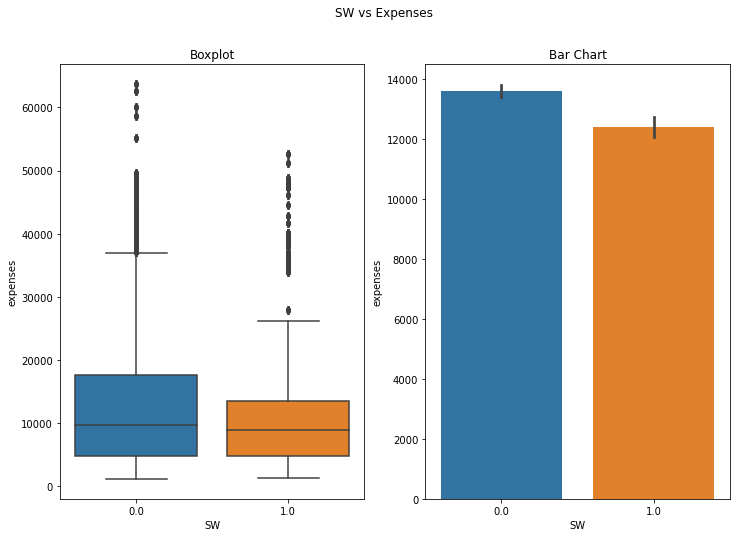

In [21]:
for feature in data.columns:
    if feature == 'expenses':
        continue
    elif feature in ['age', 'bmi']:
        numerical(feature)
    else:
        categorical(feature)

In [22]:
data.drop(columns = ['region', 'bmi_cat'], inplace=True)

### Data Standardization

In [23]:
scaler = RobustScaler()

data[['age', 'children', 'expenses']] = scaler.fit_transform(data[['age', 'children', 'expenses']])

## Model Building

### train_test_split

In [24]:
y_data = data['expenses']
x_data = data.iloc[:,:12]

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15)

### Multiple Linear Regression

In [26]:
#regression object
mlr = LinearRegression()

#training the model
mlr.fit(x_train, y_train)

#predict values
pred_mlr = mlr.predict(x_test)

### Polynomial Regression

In [27]:
poly_reg = PolynomialFeatures(degree=2)
x_poly_data  = poly_reg.fit_transform(x_data)
x_poly_train, x_poly_test = train_test_split(x_poly_data, test_size = 0.15)


lin_reg2 = LinearRegression()
lin_reg2.fit(x_poly_train,y_train)
 
pred_poly = lin_reg2.predict(x_poly_test)

### Ridge Regression

In [28]:
RR = Ridge(alpha=0.01)

RR.fit(x_poly_train, y_train)

yhat_ridge = RR.predict(x_poly_test)

 #### tune hyperparameters (alpha) for Ridge Regression


In [29]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [30]:
grid = dict()
grid['alpha'] = [0.01, 0.03, 0.1, 0.3, 1]
search = GridSearchCV(RR, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results=search.fit(x_data, y_data)
print('Best Estimate for Hyper Parameter Tuning : ', str(results.best_estimator_))

best_alpha_str = str(results.best_estimator_)
best_alpha = int(re.findall('\d', best_alpha_str)[0])
best_alpha

Best Estimate for Hyper Parameter Tuning :  Ridge(alpha=0.01)


0

In [31]:
#final Ridge Regression model:

RR = Ridge(alpha = best_alpha)
RR.fit(x_poly_train, y_train)
pred_ridge = RR.predict(x_poly_test)

### Decision Tree Regressor

In [32]:
from sklearn.tree import DecisionTreeRegressor

In [33]:
dec_tree_reg = DecisionTreeRegressor(max_depth=5, random_state=13)  
dec_tree_reg.fit(x_train, y_train) 
pred_dec_tree = dec_tree_reg.predict(x_test)

### Random Forest Regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
rand_forr_reg = RandomForestRegressor(n_estimators=400, max_depth=5, random_state=13)  
rand_forr_reg.fit(x_train, y_train)
pred_rand_forr = rand_forr_reg.predict(x_test)

## Evaluation Metrics

In [36]:
def evaluate(estimator, pred_val):
    if estimator == lin_reg2:
        x = PolynomialFeatures(degree=2).fit_transform(x_data)
    else:
        x = x_data
    r2 = r2_score(y_test, pred_val)
    rmse = np.sqrt(mean_squared_error(y_test, pred_val))
    score = cross_val_score(estimator, x, y_data, cv=4).mean()
    return r2, rmse, score

In [37]:
#Linear Regression
mlr_r2, mlr_rmse, mlr_cvscore = evaluate(mlr, pred_mlr)
print(mlr_r2, mlr_rmse, mlr_cvscore)

0.7586106660931582 0.5067680689385282 0.7580489850172041


In [38]:
#Polynomial Regression
poly_r2, poly_rmse, poly_cvscore = evaluate(lin_reg2, pred_poly)
print(poly_r2, poly_rmse, poly_cvscore)

-0.004805503955787049 1.0339301671728685 0.8710948320283991


In [39]:
#Ridge Regression
ridge_r2, ridge_rmse, ridge_cvscore = evaluate(RR, pred_ridge)
print(ridge_r2, ridge_rmse, ridge_cvscore)

-0.038904193528781494 1.0513273291406078 0.7581614390979416


In [40]:
#Decision Tree Regressor
dec_tree_r2, dec_tree_rmse, dec_tree_cvscore = evaluate(dec_tree_reg, pred_dec_tree)
print(dec_tree_r2, dec_tree_rmse, dec_tree_cvscore)

0.8762659596941561 0.36282299290124004 0.8771003706082887


In [41]:
#Random Forest Regressor
ran_r2, ran_rmse, ran_cvscore = evaluate(rand_forr_reg, pred_rand_forr)
print(ran_r2, ran_rmse, ran_cvscore)

0.8820973807326271 0.35417013009549575 0.8824285060022966


### Comparing Model perfomances

In [42]:
r2_scores = [mlr_r2, poly_r2, ridge_r2, dec_tree_r2, ran_r2]
rmse_scores = [mlr_rmse, poly_rmse, ridge_rmse, dec_tree_rmse, ran_rmse]
cross_val_scores  = [mlr_cvscore, poly_cvscore, ridge_cvscore, dec_tree_cvscore, ran_cvscore]

In [43]:
models_comparison = pd.DataFrame([r2_scores, rmse_scores, cross_val_scores], 
                                 columns = ['Multiple Linear Regression', 'Polynomial Regression', 'Ridge Regression', 
                                          'Decision Tree Regressor', 'Random Forest Regressor'],
                                 index = ['R2 score', 'RMSE score', 'Cross Validation Score'])

In [44]:
models_comparison

,Multiple Linear Regression,Polynomial Regression,Ridge Regression,Decision Tree Regressor,Random Forest Regressor
R2 score,0.758611,-0.004806,-0.038904,0.876266,0.882097
RMSE score,0.506768,1.033930,1.051327,0.362823,0.354170
Cross Validation Score,0.758049,0.871095,0.758161,0.877100,0.882429


 #### Decision Tree Regressor and Random Forest Regressor fits to the model the best 

In [45]:
#training the model with all data available
rand_forr_reg.fit(x_data, y_data)
dec_tree_reg.fit(x_data, y_data)

DecisionTreeRegressor(max_depth=5, random_state=13)

## Overfitting/Underfitting

In [46]:
y_pred = rand_forr_reg.predict(x_data)
y_pred2 = dec_tree_reg.predict(x_data)

#### Residual Plot and Scatterplot

In [47]:
def evaluate_model_vis(sns_fun):
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    #fig.title('Decision Tree Regression vs Random Forest Regression perfomance')
    
    sns_fun(ax=axes[0], x=y_pred, y=y_data)
    axes[0].set_title('Decision Tree Regressor')
    plt.xlabel('predicted values')
    plt.ylabel('actual values')
    
    sns_fun(ax=axes[1], x=y_pred2, y=y_data)
    axes[1].set_title('Random Forest Regressor')
    plt.xlabel('predicted values')
    plt.ylabel('actual values')
    
    plt.show()

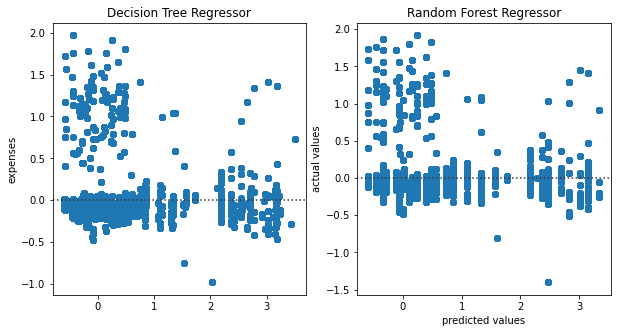

In [48]:
evaluate_model_vis(sns.residplot)

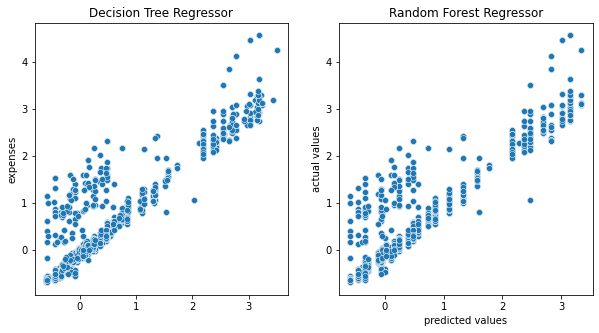

In [49]:
evaluate_model_vis(sns.scatterplot)

#### histogram

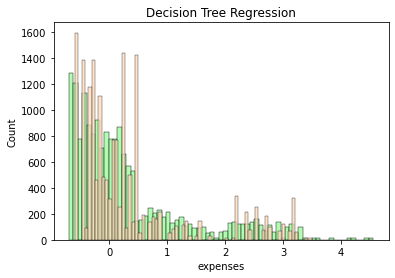

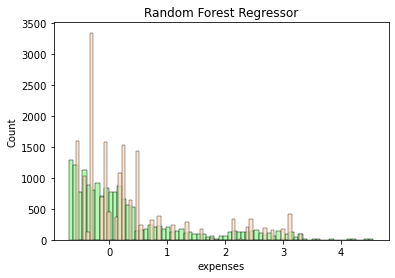

In [50]:
a1= sns.histplot(y_data, color = 'palegreen')
a2= sns.histplot(y_pred,   color = 'peachpuff', ax=a1)
plt.title('Decision Tree Regression')
plt.show()

a1= sns.histplot(y_data, color = 'palegreen')
a2= sns.histplot(y_pred2,   color = 'peachpuff', ax=a1)
plt.title('Random Forest Regressor')
plt.show()

the underfitting is due to noise in data.<br><br>
It seems that Random Forest Regressor fits the data best and so, we will use <b>Random Forest Regressor </b>for our application


### final model

In [51]:
rand_forr_reg.fit(x_data, y_data)

RandomForestRegressor(max_depth=5, n_estimators=400, random_state=13)

## Model Serialization

In [52]:
# Save the Modle to file in the current working directory

Pkl_Filename = "insurance_premium_prediction_model.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(rand_forr_reg, file)

In [53]:
# Load the Model back from file
with open('insurance_premium_prediction_model.pkl', 'rb') as file:  
    model = pickle.load(file)

#use model.predict(vec) for predicting values

## Deploy